In [1]:
import math
import numpy as np
import numpy
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import matplotlib.pyplot as plt
import urllib

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
from skimage.measure import label, regionprops
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from multiprocessing import Pool, cpu_count
import community  # Louvain algorithm package

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

2023-07-23 00:04:16.545811: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-23 00:04:16.674268: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-23 00:04:17.750639: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
os.listdir('data')

['label', 'image', 'bwmask']

# Step 1: Data Preprocessing


## Load the annotated cell images and masks

In [5]:
mask_dir = 'data/bwmask'

In [6]:
def get_file_names(root_dir):
    image = []
    mask = []
    label= []
    for i in sorted(os.listdir(root_dir)):        
              for frame in sorted(os.listdir(path.join (root_dir,i))):
                  if i == 'bwmask':
                    mask.append(path.join (root_dir,i,frame))
                  elif i == 'label':
                    label.append(path.join(root_dir,i,frame))
                  else:
                    image.append(path.join(root_dir,i,frame))

    data_df = pd.DataFrame(data =(zip(image,mask,label)),columns = ['image','bwmask','label'])
    return data_df

In [7]:
data_df = get_file_names('data/')
data_df.tail(10)

,image,bwmask,label
43,data/image/ID319_A1_Regione-0.jp2-crop_slice_9...,data/bwmask/ID319_A1_Regione-0.jp2-crop_slice_...,data/label/ID319_A1_Regione-0.jp2-crop_slice_9...
44,data/image/ID319_A1_Regione-0.jp2-crop_slice_9...,data/bwmask/ID319_A1_Regione-0.jp2-crop_slice_...,data/label/ID319_A1_Regione-0.jp2-crop_slice_9...
45,data/image/ID319_A1_Regione-1.jp2-crop_slice_2...,data/bwmask/ID319_A1_Regione-1.jp2-crop_slice_...,data/label/ID319_A1_Regione-1.jp2-crop_slice_2...
46,data/image/ID319_A1_Regione-1.jp2-crop_slice_c...,data/bwmask/ID319_A1_Regione-1.jp2-crop_slice_...,data/label/ID319_A1_Regione-1.jp2-crop_slice_c...
47,data/image/ID319_A1_Regione-1.jp2-crop_slice_c...,data/bwmask/ID319_A1_Regione-1.jp2-crop_slice_...,data/label/ID319_A1_Regione-1.jp2-crop_slice_c...
48,data/image/ID319_A1_Regione-1.jp2-crop_slice_c...,data/bwmask/ID319_A1_Regione-1.jp2-crop_slice_...,data/label/ID319_A1_Regione-1.jp2-crop_slice_c...
49,data/image/ID343_A1b-3.jp2-crop_slice_18.png,data/bwmask/ID343_A1b-3.jp2-crop_slice_18.png,data/label/ID343_A1b-3.jp2-crop_slice_18.tif
50,data/image/ID343_A1b-3.jp2-crop_slice_6.png,data/bwmask/ID343_A1b-3.jp2-crop_slice_6.png,data/label/ID343_A1b-3.jp2-crop_slice_6.tif
51,data/image/ID343_A1b-3.jp2-crop_slice_7.png,data/bwmask/ID343_A1b-3.jp2-crop_slice_7.png,data/label/ID343_A1b-3.jp2-crop_slice_7.tif
52,data/image/ID4_A1_Regione-0-crop_slice_4.png,data/bwmask/ID4_A1_Regione-0-crop_slice_4.png,data/label/ID4_A1_Regione-0-crop_slice_4.tif


### Display the images per row

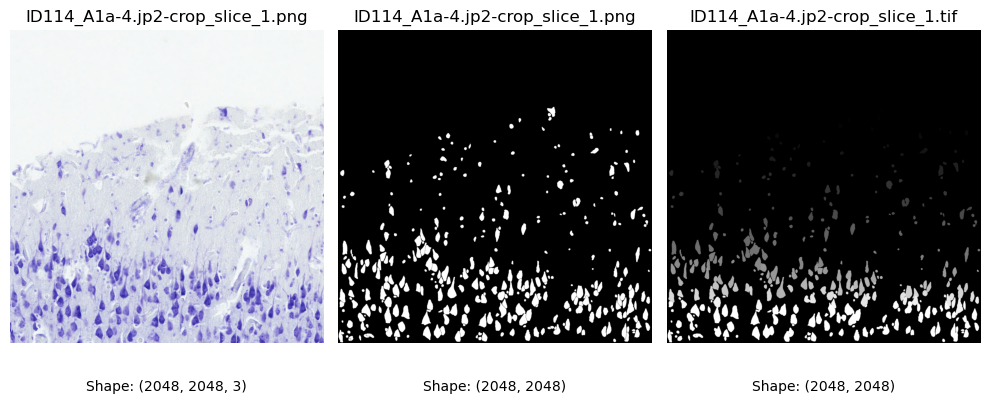

In [8]:
def strip_path(path):
  """Strips the path and returns only the file name.

  Args:
    path: The path to the file.

  Returns:
    The file name.
  """

  filename = os.path.basename(path)
  return filename


def display_images(row):
    """
    Displays all image formats in a row.

    Args:
        row: The row number of the image.

    """
    image_path = row['image']
    bwmask_path = row['bwmask']
    label_path = row['label']

    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    
    img1 = Image.open(image_path)
    imarray1 = numpy.array(img1)
    axs[0].imshow(img1)
    axs[0].set_title(strip_path(image_path))
    axs[0].axis('off')
    axs[0].text(0.5, -0.15, f'Shape: {imarray1.shape}', ha='center', transform=axs[0].transAxes)

    img2 = Image.open(bwmask_path)
    imarray2 = numpy.array(img2)
    axs[1].imshow(img2)
    axs[1].set_title(strip_path(bwmask_path))
    axs[1].axis('off')
    axs[1].text(0.5, -0.15, f'Shape: {imarray2.shape}', ha='center', transform=axs[1].transAxes)

    img3 = Image.open(label_path)
    imarray3 = numpy.array(img3)
    axs[2].imshow(img3)
    axs[2].set_title(strip_path(label_path))
    axs[2].axis('off')
    axs[2].text(0.5, -0.15, f'Shape: {imarray3.shape}', ha='center', transform=axs[2].transAxes)


    plt.tight_layout()

    plt.show()

# Display images from the first row of the DataFrame
display_images(data_df.iloc[0])


## Extract protein localization and interaction information from the masks


In [9]:
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt

def extract_protein_information(mask_dir, batch_size=50, min_area_threshold=10000):
    mask_files = os.listdir(mask_dir)
    num_masks = len(mask_files)

    # Process masks sequentially
    for i in range(0, num_masks, batch_size):
        batch_mask_files = mask_files[i:i + batch_size]

        protein_info = []  # Clear protein_info after each batch

        for mask_file in batch_mask_files:
            mask_path = os.path.join(mask_dir, mask_file)
            image_name, _ = os.path.splitext(mask_file)

            # Use context manager for Image.open
            with Image.open(mask_path) as img:
                mask = np.array(img)

                # Perform connected component labeling
                labeled_mask = label(mask)

                # Calculate protein localization information
                for region in regionprops(labeled_mask):
                    if region.area >= min_area_threshold:  # Set a minimum area threshold to filter out noise
                        y, x = region.centroid
                        protein_info.append({
                            'image_name': image_name,
                            'protein_id': region.label,
                            'area': region.area,
                            'centroid_x': x,
                            'centroid_y': y,
                            'bbox': region.bbox
                        })

        # Identify interacting regions
        if len(protein_info) > 1:
            interacting_pairs = set()
            for i in range(len(protein_info)):
                for j in range(i + 1, len(protein_info)):
                    bbox_i = protein_info[i]['bbox']
                    bbox_j = protein_info[j]['bbox']
                    if do_boxes_intersect(bbox_i, bbox_j):
                        interacting_pairs.add((protein_info[i]['protein_id'], protein_info[j]['protein_id']))

            # Add interacting pairs to protein_info
            for pair in interacting_pairs:
                protein_info.append({
                    'image_name': image_name,
                    'protein_id': f'interaction_{pair[0]}_{pair[1]}',
                    'area': -1,  # Indicate that it's an interaction region
                    'centroid_x': -1,
                    'centroid_y': -1,
                    'bbox': (-1, -1, -1, -1)
                })

        # Use yield to return each batch's DataFrame
        df = pd.DataFrame(protein_info)
        yield df
        
def do_boxes_intersect(bbox1, bbox2):
    # Check if two bounding boxes intersect
    y1_min, x1_min, y1_max, x1_max = bbox1
    y2_min, x2_min, y2_max, x2_max = bbox2
    return not (x1_max < x2_min or x1_min > x2_max or y1_max < y2_min or y1_min > y2_max)



In [10]:
df = pd.DataFrame()
for batch_data in extract_protein_information(mask_dir, batch_size=50, min_area_threshold=10):
    batch_data = pd.concat([df, batch_data])
batch_data.shape

(2851, 6)

In [11]:
batch_data.head(10)

,image_name,protein_id,area,centroid_x,centroid_y,bbox
0,ID319_A1_Regione-0.jp2-crop_slice_93,1,1038.0,1633.904624,20.218690,"(2, 1614, 36, 1657)"
1,ID319_A1_Regione-0.jp2-crop_slice_93,2,357.0,1661.400560,13.532213,"(3, 1652, 26, 1672)"
2,ID319_A1_Regione-0.jp2-crop_slice_93,3,647.0,700.979907,35.381762,"(19, 688, 54, 715)"
3,ID319_A1_Regione-0.jp2-crop_slice_93,4,2356.0,1814.254669,50.970289,"(23, 1783, 84, 1847)"
4,ID319_A1_Regione-0.jp2-crop_slice_93,5,398.0,959.288945,34.753769,"(25, 948, 46, 971)"
5,ID319_A1_Regione-0.jp2-crop_slice_93,6,412.0,602.905340,42.385922,"(27, 591, 58, 616)"
6,ID319_A1_Regione-0.jp2-crop_slice_93,7,480.0,1387.839583,43.454167,"(28, 1378, 58, 1399)"
7,ID319_A1_Regione-0.jp2-crop_slice_93,8,354.0,1077.056497,53.675141,"(44, 1065, 66, 1090)"
8,ID319_A1_Regione-0.jp2-crop_slice_93,9,325.0,1421.433846,53.498462,"(44, 1412, 64, 1432)"
9,ID319_A1_Regione-0.jp2-crop_slice_93,10,625.0,843.072000,62.280000,"(50, 827, 77, 860)"


# Step 2: Graph Network Generation

In [12]:
import networkx as nx

def create_cell_network_graph(protein_data):
    G = nx.Graph()

    # Add nodes to the graph
    for _, row in protein_data.iterrows():
        G.add_node(str(row['protein_id']), area=row['area'], centroid=(row['centroid_x'], row['centroid_y']))

    # Add edges for interacting pairs
    for _, row in protein_data.iterrows():
        if str(row['protein_id']).startswith('interaction_'):
            _, node1, node2 = str(row['protein_id']).split('_')
            G.add_edge(node1, node2)

    return G


### Create a graph data structure to represent the cell network

In [13]:
protein_data = pd.concat(list(extract_protein_information(mask_dir, batch_size=64, min_area_threshold=50)))
cell_network_graph = create_cell_network_graph(protein_data)
print(cell_network_graph)

Graph with 180294 nodes and 126949 edges


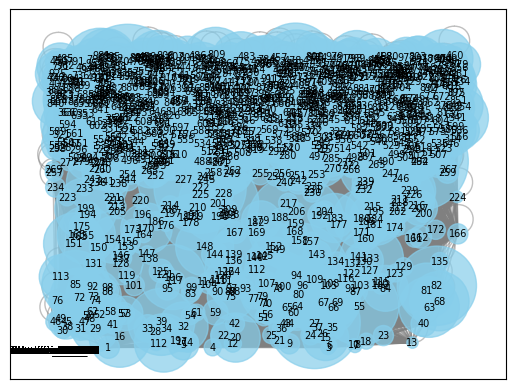

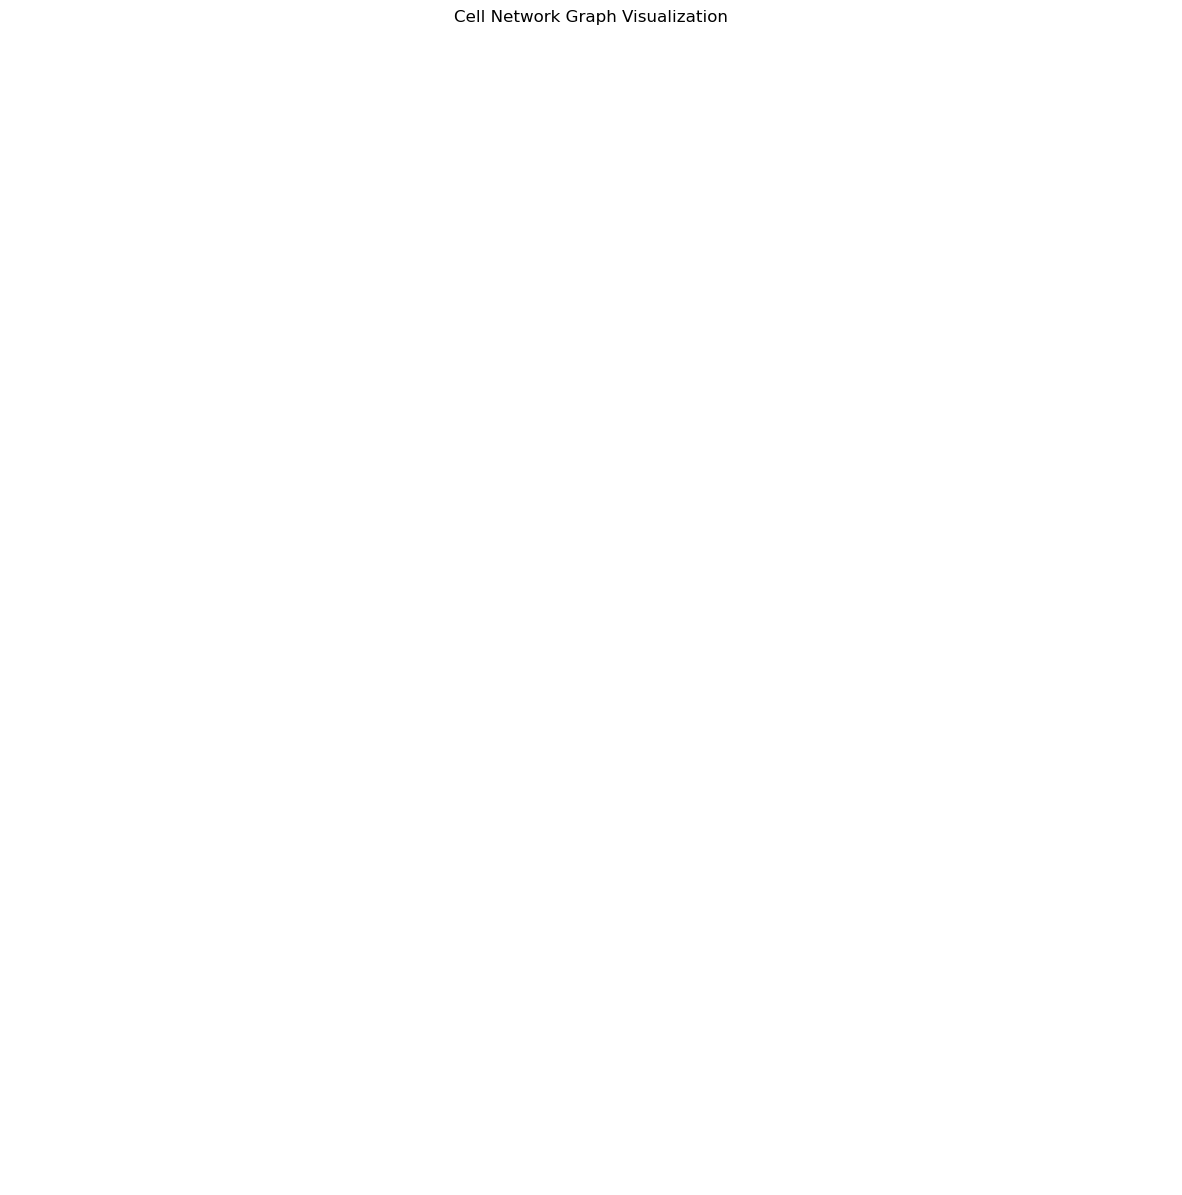

In [14]:
# Visualization of the cell_network_graph
pos = nx.get_node_attributes(cell_network_graph, 'centroid')  # Get positions of nodes

node_sizes = [data['area']/2 for node, data in cell_network_graph.nodes(data=True)]
nx.draw_networkx_nodes(cell_network_graph, pos, node_size=node_sizes, node_color='skyblue', alpha=0.7)

nx.draw_networkx_edges(cell_network_graph, pos, edge_color='gray', alpha=0.5)
labels = {node: str(node) for node in cell_network_graph.nodes()}
nx.draw_networkx_labels(cell_network_graph, pos, labels, font_size=7, font_color='black')

# Set plot properties
plt.figure(figsize = (10,10))
plt.title("Cell Network Graph Visualization")
plt.axis('off')
plt.show()

# Network Analysis using Louvain Algorithm

In [15]:
from community import community_louvain
# import community as community_louvain  # Louvain algorithm package

partition = community_louvain.best_partition(cell_network_graph)

# Use NetworkX library to implement the Louvain algorithm for community detection
# Partition the cell network into communities (protein complexes)
# Analyze the communities to identify important nodes and pathways
# Analyze the communities
communities = {}
for node, community_id in partition.items():
    if community_id not in communities:
        communities[community_id] = []
    communities[community_id].append(node)

# Print the communities
print("Identified Communities (Protein Complexes):")
for community_id, nodes in communities.items():
    print(f"Community {community_id}: {nodes}")

Identified Communities (Protein Complexes):
Community 0: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




# Network Visualization


#### Use NetworkX or other libraries like Matplotlib or Plotly to visualize the cell network
#### Visualize protein complexes as separate subgraphs or colors for better understanding


In [ ]:
import threading

# Get the number of protein complexes (communities)
num_communities = max(partition.values()) + 1

# Separate protein complexes into subgraphs based on community IDs
def _separate_protein_complexes(community_id):
    protein_complexes.append(cell_network_graph.subgraph([node for node in cell_network_graph.nodes if partition[node] == community_id]))

num_threads = 4
protein_complexes = []
threads = []

for community_id in tqdm(range(num_communities)):
    thread = threading.Thread(target=_separate_protein_complexes, args=(community_id,))
    thread.start()
    threads.append(thread)

for thread in threads:
    thread.join()

 17%|██████████████                                                                   | 31062/179317 [16:45<1:18:30, 31.48it/s]

In [ ]:

def filter_nodes_by_degree(graph, threshold=50):
    degree_centrality = nx.degree_centrality(graph)
    important_nodes = {node for node, centrality in degree_centrality.items() if centrality > threshold}
    return important_nodes

def create_subgraph_for_community(graph, community_id):
    return graph.subgraph([node for node in graph.nodes if partition[node] == community_id])

def limit_cells_to_display(graph, num_cells_to_display):
    return sorted(graph.nodes(), key=lambda x: nx.degree(graph, x), reverse=True)[:num_cells_to_display]

def edge_bundling_edges(graph, cells_to_display):
    return [(u, v) for u, v in graph.edges() if u in cells_to_display and v in cells_to_display]

def get_node_sizes(graph, cells_to_display, important_nodes):
    node_sizes = []
    for node in cells_to_display:
        if node in important_nodes:
            node_data = graph.nodes[node]
            node_sizes.append(node_data['area'])
        else:
            node_sizes.append(30)  # A fixed size for non-important nodes
    return node_sizes


In [ ]:
# Function to visualize the cell network graph
def visualize_cell_network_graph(graph, cells_to_display, important_nodes, pos):
    node_sizes = get_node_sizes(graph, cells_to_display, important_nodes)

    nx.draw_networkx_nodes(graph, pos, nodelist=cells_to_display, node_size=node_sizes, node_color='skyblue', alpha=0.7)
    non_important_nodes_list = [node for node in cells_to_display if node not in important_nodes]
    nx.draw_networkx_nodes(graph, pos, nodelist=non_important_nodes_list, node_size=30, node_color='gray', alpha=0.7)

    edges = list(graph.edges)
    edge_positions = np.array([(pos[u], pos[v]) for u, v in edges], dtype='f')
    lc = LineCollection(edge_positions, colors='gray', linewidths=0.5, alpha=0.5)
    plt.gca().add_collection(lc)

    plt.title("Cell Network Graph Visualization")
    plt.axis('off')
    plt.show()


In [ ]:
import networkx as nx
import plotly.graph_objects as go

def visualize_protein_complexes(cell_network_graph, protein_complexes, pos):
    num_communities = len(protein_complexes)
    colors = plt.cm.get_cmap('tab20', num_communities)

    fig = go.Figure()

    for i, protein_complex in enumerate(protein_complexes):
        # Extract nodes and edges of the protein complex from the main graph
        nodes = [node for node in protein_complex.nodes() if node in cell_network_graph]
        edges = [edge for edge in cell_network_graph.edges() if edge[0] in nodes and edge[1] in nodes]

        # Create a subgraph for the protein complex
        complex_subgraph = nx.Graph()
        complex_subgraph.add_nodes_from(nodes)
        complex_subgraph.add_edges_from(edges)

        # Get positions of nodes in the subgraph
        complex_pos = {node: pos[node] for node in nodes}

        # Create a scatter plot for the nodes
        node_trace = go.Scatter(x=[], y=[], mode='markers', marker=dict(size=10, color=colors(i)))
        for node, (x, y) in complex_pos.items():
            node_trace['x'] += tuple([x])
            node_trace['y'] += tuple([y])
        fig.add_trace(node_trace)

        # Create a line plot for the edges
        edge_trace = go.Scatter(x=[], y=[], mode='lines')
        for u, v in complex_subgraph.edges():
            edge_trace['x'] += tuple([complex_pos[u][0], complex_pos[v][0], None])
            edge_trace['y'] += tuple([complex_pos[u][1], complex_pos[v][1], None])
        fig.add_trace(edge_trace)

    # Set plot layout properties
    fig.update_layout(title_text="Protein Complexes Visualization", showlegend=False, xaxis=dict(showticklabels=False), yaxis=dict(showticklabels=False))
    fig.show()


In [ ]:

# Assuming you have already created the 'cell_network_graph', 'partition', and 'protein_complexes' variables.
important_nodes = filter_nodes_by_degree(cell_network_graph, 50)
cells_to_display = limit_cells_to_display(cell_network_graph, 100000000)
pos = nx.get_node_attributes(cell_network_graph, 'centroid')


In [ ]:
visualize_cell_network_graph(cell_network_graph, cells_to_display, important_nodes, pos)

In [ ]:

# visualize_protein_complexes(cell_network_graph, protein_complexes, pos)


In [ ]:
import matplotlib as mpl
import networkx as nx

def draw_cell_network_with_protein_complexes(graph, partition, protein_complexes, num_cells_to_display=50, node_degree_threshold=0.05):
    # important_nodes = filter_nodes_by_degree(graph, node_degree_threshold)
    # cells_to_display = limit_cells_to_display(graph, num_cells_to_display)
    # pos = nx.get_node_attributes(graph, 'centroid')
    
    # Get node sizes based on importance
    node_sizes = get_node_sizes(graph, cells_to_display, important_nodes)
    
    # Draw important nodes with their area as node size and color based on communities
    important_node_colors = [partition[node] for node in cells_to_display if node in important_nodes]
    nx.draw_networkx_nodes(graph, pos, nodelist=cells_to_display, node_size=node_sizes, node_color=important_node_colors, cmap='viridis', alpha=0.7)

    # Draw non-important nodes with a fixed size and color (if desired)
    non_important_nodes_list = [node for node in cells_to_display if node not in important_nodes]
    nx.draw_networkx_nodes(graph, pos, nodelist=non_important_nodes_list, node_size=30, node_color='gray', alpha=0.7)

    # Draw edges using LineCollection for edge bundling effect
    edges = edge_bundling_edges(graph, cells_to_display)
    edge_colors = [partition[u] for u, v in edges]
    edge_positions = np.array([(pos[u], pos[v]) for u, v in edges], dtype='f')
    lc = LineCollection(edge_positions, colors='gray', linewidths=0.5, alpha=0.5)
    plt.gca().add_collection(lc)

    # Draw protein complexes as subgraphs with distinct colors
    num_communities = max(partition.values()) + 1
    colors = mpl.colormaps.get_cmap('tab20')
    for i, protein_complex in enumerate(protein_complexes):
        nx.draw(protein_complex, pos, node_size=30, node_color=[colors(i)], alpha=0.7, edge_color='gray', linewidths=0.5)

    # Label only important nodes
    important_node_labels = {node: str(node) for node in cells_to_display if node in important_nodes}
    nx.draw_networkx_labels(graph, pos, labels=important_node_labels, font_size=10, font_color='black')

    # Set plot properties
    plt.title("Cell Network Graph with Protein Complexes (Limited Cells)")
    plt.axis('off')
    plt.show()


In [ ]:
# draw_cell_network_with_protein_complexes(cell_network_graph, partition, protein_complexes)

In [ ]:

def draw_cell_network_with_protein_complexes1(graph, partition, protein_complexes, num_cells_to_display=50, node_degree_threshold=0.05):
    
    # Get node sizes based on importance
    node_sizes = get_node_sizes(graph, cells_to_display, important_nodes)
    
    # Create subplots for main graph and protein complexes
    fig = make_subplots(rows=1, cols=2, subplot_titles=["Cell Network Graph", "Protein Complexes"])
    
    # Draw important nodes with their area as node size and color based on communities
    important_node_colors = [partition[node] for node in cells_to_display if node in important_nodes]
    node_trace = go.Scatter(x=[], y=[], mode='markers', text=[], marker=dict(size=node_sizes, color=important_node_colors, colorscale='viridis', colorbar=dict(title='Community')))
    for node in cells_to_display:
        x, y = pos[node]
        node_trace['x'] += tuple([x])
        node_trace['y'] += tuple([y])
        node_trace['text'] += tuple([node])
    fig.add_trace(node_trace, row=1, col=1)

    # Draw edges
    edge_trace = go.Scatter(x=[], y=[], line=dict(width=0.5, color='gray'), hoverinfo='none', mode='lines')
    for edge in edge_bundling_edges(graph, cells_to_display):
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_trace['x'] += tuple([x0, x1, None])
        edge_trace['y'] += tuple([y0, y1, None])
    fig.add_trace(edge_trace, row=1, col=1)

    # Draw protein complexes as subgraphs with distinct colors
    colors = plt.cm.get_cmap('tab20', len(protein_complexes))
    for i, protein_complex in enumerate(protein_complexes):
        complex_x, complex_y = zip(*[pos[node] for node in protein_complex.nodes()])
        complex_trace = go.Scatter(x=complex_x, y=complex_y, mode='markers', marker=dict(size=10, color=[colors(i)]))
        fig.add_trace(complex_trace, row=1, col=2)

    # Set axis properties
    fig.update_xaxes(showticklabels=False, showgrid=False, zeroline=False, row=1, col=1)
    fig.update_yaxes(showticklabels=False, showgrid=False, zeroline=False, row=1, col=1)
    fig.update_xaxes(showticklabels=False, showgrid=False, zeroline=False, row=1, col=2)
    fig.update_yaxes(showticklabels=False, showgrid=False, zeroline=False, row=1, col=2)

    # Set layout properties
    fig.update_layout(title_text="Cell Network Graph with Protein Complexes (Limited Cells)", showlegend=False)
    fig.show()



In [ ]:
# Call function
# draw_cell_network_with_protein_complexes1(cell_network_graph, partition, protein_complexes)

In [ ]:
from matplotlib.image import imread

# Set the folder path
folder_path = "test_image"

# Get the names of the first two images in the folder
image_names = os.listdir(folder_path)[:2]

# Load the first two images
image_path = imread(os.path.join(folder_path, image_names[0]))
mask_path = imread(os.path.join(folder_path, image_names[1]))

# Plot the first two images
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(mask_path)
plt.title(image_names[1])

plt.subplot(122)
plt.imshow(image_path)
plt.title(image_names[0])

plt.show()

In [ ]:
from skimage.measure import label, regionprops

# Function to create the cell network graph
def create_cell_network_graph(image_path, mask_path, min_area_threshold=100, edge_threshold=0.1):
    # Load the image and mask
    img = Image.open(image_path)
    mask = Image.open(mask_path)

    # Segment cells from the mask and calculate region properties
    labeled_cells = label(np.array(mask))
    cell_properties = regionprops(labeled_cells)

    # Create a graph
    cell_network_graph2 = nx.Graph()

    # Add nodes (cells) to the graph
    for cell in cell_properties:
        if cell.area >= min_area_threshold:
            cell_network_graph.add_node(cell.label, area=cell.area, centroid=cell.centroid)

    # Add edges (interactions) to the graph based on spatial proximity
    centroids = nx.get_node_attributes(cell_network_graph2, 'centroid')
    for u, v in nx.non_edges(cell_network_graph):
        distance = np.sqrt((centroids[u][0] - centroids[v][0]) ** 2 + (centroids[u][1] - centroids[v][1]) ** 2)
        if distance <= edge_threshold:
            cell_network_graph.add_edge(u, v)

    return cell_network_graph

In [ ]:
# Create the cell network graph
cell_network_graph = create_cell_network_graph(image_path, mask_path)
print(cell_network_graph)

In [ ]:
# Evaluate the cell network graph
def evaluate_cell_network_graph(graph):
    # Check if the graph has any edges
    if graph.number_of_edges() == 0:
        raise ValueError("The graph has no edges, and the modularity is undefined.")
        
    # Calculate modularity using Louvain algorithm for community detection
    partition = community.best_partition(graph)
    modularity = community.modularity(partition, graph)

    # Calculate overall connectivity and density
    connectivity = graph.number_of_edges()
    density = nx.density(graph)

    # Calculate robustness by simulating node removal
    num_nodes_removed = 10
    removed_nodes = np.random.choice(list(graph.nodes()), num_nodes_removed, replace=False)
    robustness = 0
    for node in removed_nodes:
        temp_graph = graph.copy()
        temp_graph.remove_node(node)
        if nx.is_connected(temp_graph):
            robustness += 1
    robustness /= num_nodes_removed

    # Calculate average path length and diameter
    avg_path_length = nx.average_shortest_path_length(graph)
    diameter = nx.diameter(graph)

    # Calculate clustering coefficient
    clustering_coefficient = nx.average_clustering(graph)

    return modularity, connectivity, density, robustness, avg_path_length, diameter, clustering_coefficient

In [ ]:
# Replace 'image_path' and 'mask_path' with the paths to your image and mask files.
image_path = 'test_image/1-scimpanze-1dx-2sx_1_slice_4.png'
mask_path = 'test_image/1-scimpanze-1dx-2sx_1_slice_4_bwmask.png'

# Create the cell network graph
cell_network_graph = create_cell_network_graph(image_path, mask_path)

# Evaluate the cell network graph
modularity, connectivity, density, robustness, avg_path_length, diameter, clustering_coefficient = evaluate_cell_network_graph(cell_network_graph)

# Print the evaluation results
print("Modularity:", modularity)
print("Connectivity:", connectivity)
print("Density:", density)
print("Robustness:", robustness)
print("Average Path Length:", avg_path_length)
print("Diameter:", diameter)
print("Clustering Coefficient:", clustering_coefficient)